**Проект 5. Компьютер говорит "Нет"**

**1. Постановка задачи и знакомство с данными**

***1.1. Постановка задачи***

Создать скоринговую модель для предсказания дефолта клиентов банка.

***1.2. Описание структуры данных***

Рассмотрим описание структуры данных, которое нам предложено при постановке задачи.

Описания полей
- client_id - идентификатор клиента 
- app_date - дата подачи заявки 
- education - уровень образования 
- sex - пол заемщика 
- age - возраст заемщика 
- car - флаг наличия автомобиля 
- car_type - флаг автомобиля-иномарки 
- decline_app_cnt - количество отказанных прошлых заявок 
- good_work - флаг наличия “хорошей” работы 
- score_bki - скоринговый балл по данным из БКИ 
- bki_request_cnt - количество запросов в БКИ 
- region_rating - рейтинг региона 
- home_address - категоризатор домашнего адреса 
- work_address - категоризатор рабочего адреса 
- income - доход заемщика 
- sna - связь заемщика с клиентами банка 
- first_time - давность наличия информации о заемщике 
- foreign_passport - наличие загранпаспорта 
- score_bki - скоринговый балл по данным из БКИ 
- default - флаг дефолта по кредиту

***1.3. Подключение требуемых библиотек, инициализация требуемых переменных, процедур и функций***

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

In [2]:
# Списки для хранения названия признаков по типам
num_cols = [] # Числовые
cat_cols = [] # Категориальные
bin_cols = [] # Бинарные

def number_graph(data, column, title):
    """Процедура для визуализации распределений числовых признаков

    Args:
        data (DataFrame): Датафрейм с данными для посторения графика
        column (string): Название признака для посторения графика
        title (string): Заголовок графика

    """
    fig = plt.figure(figsize=(14,5))    
    
    bins = 150 if column.nunique() > 150 else column.nunique()
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=column, bins=bins).set(title=title+' (histogram)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='default', y=column, data=data).set(title=title+' (boxplot)')
    plt.show()

def outliers(column):
    """Функция для получения данных по выбросам данных

    Args:
        column (float): Значение признака данных для расчета параметров выбросов

    Returns:
        int: Количество выбросов
        float: Нижняя граница выбросов
        float: Верхняя граница выбросов
    """
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IRQ = Q3 - Q1
    min_out = Q1 - 1.5 * IRQ
    max_out = Q3 + 1.5 * IRQ
    
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

def print_outliers(df, outs):
    """Процедура для вывода количества выбросов и их доли в данных

    Args:
        df (DataFrame): Датафрейм с данными
        outs (int): Количество выбросов

    """
    percent = round(outs/len(df) * 100, 2)
    print(f'Выбросы: {outs} ({percent}%)')
    
def get_metrics(y_test, y_pred, y_prob):    
    """Функция для получения данных по метрикам

    Args:
        y_test (array): Массив значений с истинными значениями целевой переменной
        y_pred (array): Массив значений с предсказанными значениями целевой переменной
        y_prob (array): Массив значений с плотностями вероятности целевой переменной

    Returns:
        dict: Словарь с названием и значением метрики
    """
    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_prob)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    
    return metrics 

def roc_auc_graph(y_test, y_prob):
    """Процедура для визуализации ROC AUC

    Args:
        y_test (array): Массив значений с истинными значениями целевой переменной
        y_prob (array): Массив значений с плотностями вероятности целевой переменной

    """
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

***1.4. Загрузка и первичное ознакомление с данными***

In [3]:
# Чтение исходных данных
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [4]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

***Вывод:***  По результатам первичного ознакомления с данными, можно сделать вывод, что требуется проведение предобработки данных.

***1.5. Подготовка данных к предобработке***

Дополним датафрейм *df_train* недостающим реквизитом *default* с нулевыми значениями для полследующего объединения исходных датафреймов (по условиям задания). Также введем в обе исходные таблицы признак *sample* для возможности последующего обратного разбиения общего датафрейма на обучающую и тестовую выборку.

In [8]:
df_train['sample'] = 1
df_test['default'] = 0
df_test['sample'] = 0

df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Теперь датасет готов к проведению предобработки данных.

**2. Переобработка данных**

***2.1. Анализ пропусков данных***

In [9]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

***Вывод:*** Пропуски данных найдены только в поле *education*. Учтем это далее при обработке данного признака.

***2.2. Подробный анализ признаков***

Проверим уникальность признаков датасета.

In [10]:
df.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
sample                   2
dtype: int64

***Выводы.*** 
- Полностью уникальным признаком дата является *client_id*. 
- Достаточно уникальным является ппризнак *score_bki*. 
- Большое количество уникальных значений обнаружено у признака *income*. 
- Несколько десятков значений присутствует у признаков *app_date*, *age*, *bki_request_cnt*, *decline_app_cnt*. 
- Остальные признаки имеют небольшое количество уникальных знечений и скорее всего будут отнесены к категориальным или бинарным.

Учтем вышеприведенные выводы при подробном анализе вех признаков датасета. Все интересующие нас предобработанные признаки мы будем вносить в списки-переменные:
- num_cols - числовые признаки,
- cat_cols - категориальные признаки, 
- bin_cols - бинарные признаки.

***2.2.1. Признак client_id - идентификатор клиента***

Признак *client_id*, как следует из анализа уникальности признаков, является полностью уникальным. Т.е. в предложенном датасете каждая запись соответствует индивидуальному заемщику банка. Т.к. данное значение не несет полезной информации для для обучения создаваемой модели скоринга, то исключим данный признак из списка интересующих нас для постоения модели реквизитов.

***Вывод.*** Признак *client_id* не будет использоваться при обучении модели.

***2.2.2. Признак app_date - дата подачи заявки***

Дата подачи заявки может быть полезна для обучаемой модели, если ее разбить на составные части - дни, месяцы и годы и использовать отдельные копоненты даты как числовые признаки. Проведем данную предобработку. Начнем с выделени года.

In [11]:
df['app_date'] = pd.to_datetime(df['app_date'])
df['app_year'] = df['app_date'].dt.year
df['app_year'].value_counts()

2014    110148
Name: app_year, dtype: int64

Видно, что в предложенных нам данных присутствует только одно значение года - 2014 г. Для обучения модели скоринга данное неизменное значение не несет полезной информации. Исключаем это значение из параметров для рассмотрения. Далее выделяем и анализируем значение месяца.

In [12]:
df['app_month'] = df['app_date'].dt.month
df['app_month'].value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_month, dtype: int64

Из результатов видно, что данные в датасете представлены только за январь - апрель 2014 г. Это не все месяцы года, но между тем, этот признак мы можем использовать в обучаемой модели. Будем считать признак *app_month* числовым. Выделим из исходной даты день недели.

In [13]:
df['app_day'] = df['app_date'].dt.day
len(df['app_day'].value_counts())

31

Получили, что в данных присутствуют все возможные дни месяца. Будем использовать это признак в модели как числовой. Остальные признаки связаные с датой - удаляем.

In [14]:
num_cols.append('app_month')
num_cols.append('app_day')
df.drop(['app_date','app_year'], axis=1, inplace=True)

***Вывод.*** Из признака *app_date* для обучения модели выделены числовые значения дня и месяца.

***2.2.3. Признак education - уровень образования***

Данный признак имеет небольшое количество уникальных значений. Рассмотрим их значения более подробно.

In [15]:
df['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Из найденных внешник источников, нам известны расшифровки данных значений: 
- SCH - только школа, 
- GRD - бакалавр, 
- UGR - магистр, 
- PGR - магистр+стажировка, 
- ACD - высшая категория образования

Обращаем внимание, что максимальное количество значений данного параметра у заемщиков имеющих только школьное образование.

Из п.2.1. нам известно, что в данном признаке присутствуют пропуски. Исходя из предположения, что заемщики должны иметь хотя бы школьное образование, заполним пропуски значением "SCH" и посмотрим результирующее распределение признака *education*.

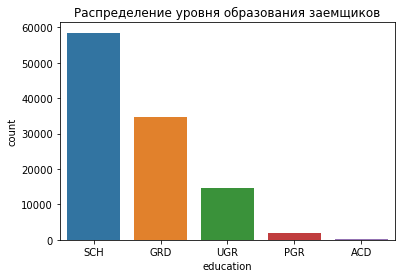

In [16]:
df['education'] = df.education.fillna('SCH')
sns.countplot(data=df, x=df['education']).set(title='Распределение уровня образования заемщиков');

По результатм анализа видно, что признак *education* имеет явную категориальную структуру. Учтем его в списке категориальных признаков для дальнейшей групповой обработки.

In [17]:
cat_cols.append('education')

***Выводы.***
- В признаке *education* произведено заполнение пропусков.
- Признак *education* является категориальным.

***2.2.4. Признак sex - пол заемщика***

Уникальных значений данного признака всего две. Ожидаемо, что это будет бинарный реквизит. Посмотрим его рапределение.

F    61836
M    48312
Name: sex, dtype: int64


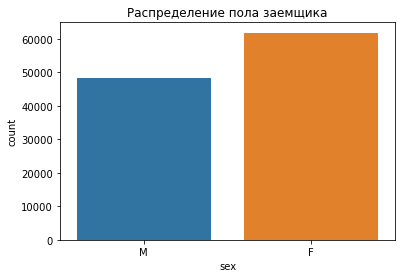

In [18]:
print(df['sex'].value_counts())
sns.countplot(data=df, x=df['sex']).set(title='Распределение пола заемщика');

где, M - мужчины, F - женщины. Из этого явно вытекает, что признак бинарный. Зафиксируем это в соответсвующем списке признаков.

In [19]:
bin_cols.append('sex')

***Выводы.***
- Из анализа разпределения признака *sex* получается женщин в предложенной выборке немного больше.
- Признак *sex* - бинарный.

***2.2.5. Признак age - возраст заемщика***

Изначально признак *age* числовой. Визуализируем его для анализа.

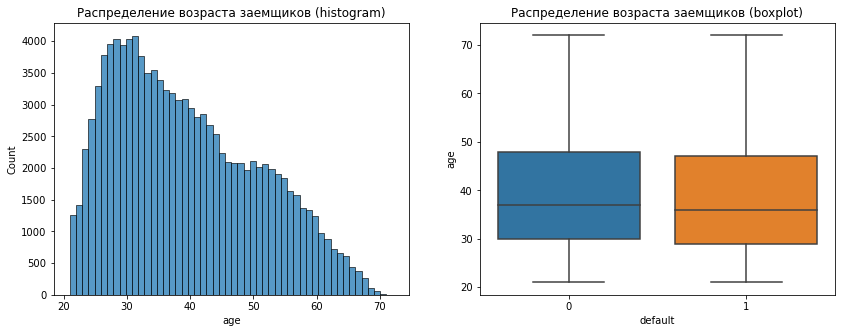

In [20]:
 
number_graph(df, df['age'], 'Распределение возраста заемщиков')

По гистограмме видно, что максимальное количество заемщиков имеет возраст порядка 30 лет. Далее эта величина почти равномерно снижается до нуля для заемщиков с возрастом ~70 лет. Виден небольшой пик в районе 50 лет. По boxplot-графикам можно сделать выводы, что значения возрастов для дефолтных и не дефолтных клиентов достаточно близки как по медиане, так и по граничным значениям.

Данный признак может быть достаточно значимым для модели скоринга. Включаем его в список числовых признаков.

In [21]:
num_cols.append('age')

***Выводы.***
- Распределение признака *age* в датасете не является нормальным.
- Распределение при знака *age* по отношению к целевому признаку *default* достаточно сбалансированно.
- Признак *age* является числовым.

***2.2.6. Признак *car* - флаг наличия автомобиля у заемщика***

Признак *car* имее два уникальных значения. Предполагется, что он может быть бинарным. Проверим это утверждение.

N    74290
Y    35858
Name: car, dtype: int64


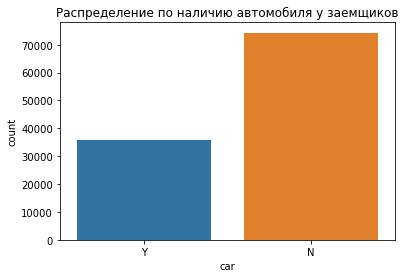

In [22]:
print(df['car'].value_counts())
sns.countplot(data=df, x=df['car']).set(title='Распределение по наличию автомобиля у заемщиков');

где, Y - есть автомобиль, N - нет автомобиля. Использование 2-х значений Y/N говорит о бинарности признака. Включим его в соответствующий смисок признаков для дальнейшей обработки. 

In [23]:
bin_cols.append('car')

***Выводы.***
1. Заемщиков без автомобиля в датасете больше.
2. Признак *car* является бинарным.

***2.2.7. Признак *car_type* - флаг автомобиля-иномарки***

Данный признак аналогичен по свойствам предыдущему. Поведем с ним те же операции.

N    89140
Y    21008
Name: car_type, dtype: int64


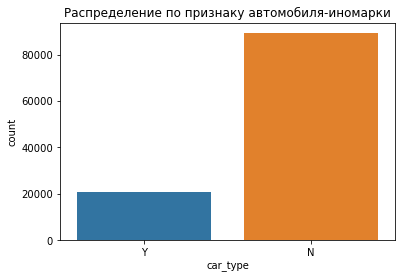

In [24]:
print(df['car_type'].value_counts())
sns.countplot(data=df, x=df['car_type']).set(title='Распределение по признаку автомобиля-иномарки');

где, Y - у заемщика автомобиль-иномарка, N - у заемщика не автомобиль-иномарка. Использование значений Y/N говорит о бинарности признака. Включим его в список бинарных признаков.

In [25]:
bin_cols.append('car_type')

*Примечание 1.* Т.к. признак *car_type* может иметь смысл при рассмотрении только при наличии у займщика автомобиля *car*, то можно говорить о наличии логической связи между данными признаками.

*Примечание 2.* Рассмотрим так же распредление заемщиков с автомобилями-иномарками по отношению к нашему целевому признаку *default*.

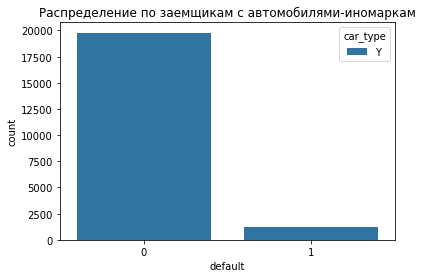

In [26]:
df_foreign = df[df['car_type'] == 'Y']
sns.countplot(data=df_foreign, x=df_foreign['default'], hue=df_foreign['car_type']).set(title='Распределение по заемщикам с автомобилями-иномаркам');

Из приведенного графика видно, что дефолты у заемщиков с автомобилями-иномарками значительно реже. Данная информация может быть интересна сотрудникам банка при определении оперативных критериев оценки дефолтов заемщиков. 

***Выводы.***
1. Примерно 20% заемщиков из датасета имеют автомобили-иномарки.
2. Дефолты у заемщиков с автомобилями-иномарками достаочно редкое явление.
3. Признак *car_type* является бинарным.

***2.2.8. Признак decline_app_cnt - количество прошлых отказанных заявок***

Признак изначально имеет числовое знчение. Рассмотрим его значения графически более подробно.

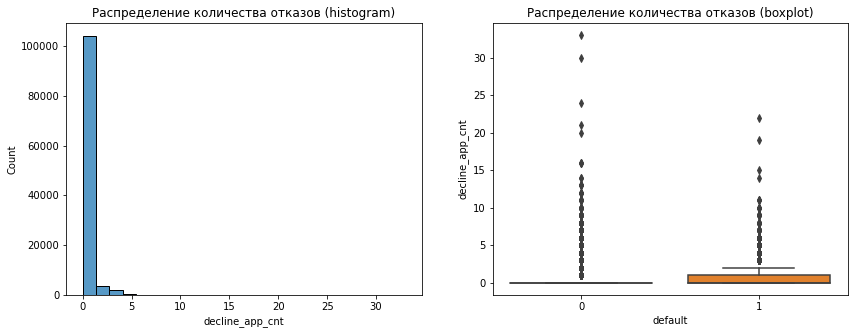

In [27]:
number_graph(df, df['decline_app_cnt'], 'Распределение количества отказов')

В гистограмме явно виден значительный дисбаланс значений признака. Подавляющее количество значений находяться в нуле. В boxplot'е видно большое количество выбросов. Нужна предобработка этого признака. Для этого проанализируем выбросы.

In [28]:
print_outliers(df, outliers(df['decline_app_cnt'])[0])

Выбросы: 18677 (16.96%)


Полученное количество выбросов достаточно велико, для того чтобы просто удалить связанные строки датасета. Рассмотрим более детально уникальные значения данного признака.

In [29]:
df['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
24        1
30        1
21        1
19        1
15        1
33        1
22        1
20        1
Name: decline_app_cnt, dtype: int64

Видно, что в первых четырех значениях сосредоточено почти 99% строк датасета. С учетом 
полученного распределения уникальных значений, признак можно считать категориальным со значениями 0,1,2,3, и с отнесением всех значений мнее 1% общего числа записей в дататасете (менее 1100) к категории 4. Выполним описанные преобразования и визиализируем результат.

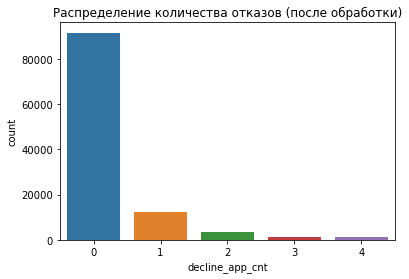

In [30]:
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
sns.countplot(data=df, x=df['decline_app_cnt']).set(title='Распределение количества отказов (после обработки)');

Получили категориальный признак, который занесем в соответствующий список признаков для последующей окончательной обработки.

In [31]:
cat_cols.append('decline_app_cnt')

***Выводы.***
1. Количество заемщиков, у которых не было отказов значительно преобладает над остальными категориями.
2. Признак *decline_app_cnt* категориальный. Проведена обработка для ограничения количества категорий.

***2.2.9. Признак good_work - флаг наличия “хорошей” работы***

Числовое значение из п.1.5. и два уникальных значения из п.2.2. для данного признака говорят о его бинарности. Проверим это утверждение.

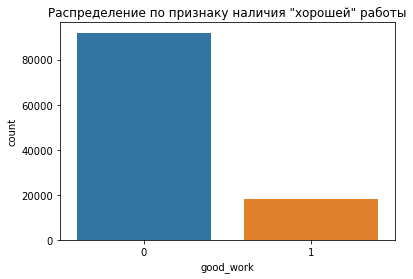

In [32]:
sns.countplot(data=df, x=df['good_work']).set(title='Распределение по признаку наличия "хорошей" работы');

где *good_work*: 0 - у заемщика нет "хорошей" работы, 1 - у заемщика есть "хорошая" работа. Не очень ясен критерий банка "хорошая" работа, но он может пригодится для обучения модели скоринга. Зафиксируем данный признак в списке бинарных признаков. Он те требует дополнительной обработки. 

In [33]:
bin_cols.append('good_work')

***Выводы.***
1. Заемщики не имеющие "хорошую" работу преобладают в предложенном датасете.
2. Признак *good_work* - бинарный.

***2.2.10. Признак score_bki - скоринговый балл по данным из БКИ***

Единственный признак в структуре данных имеющий тип float64 - числовой с плавающей точкой. Т.к. данный признак имее множество уникальных значений (см. п.2.2.), то проанализируем его графически.  

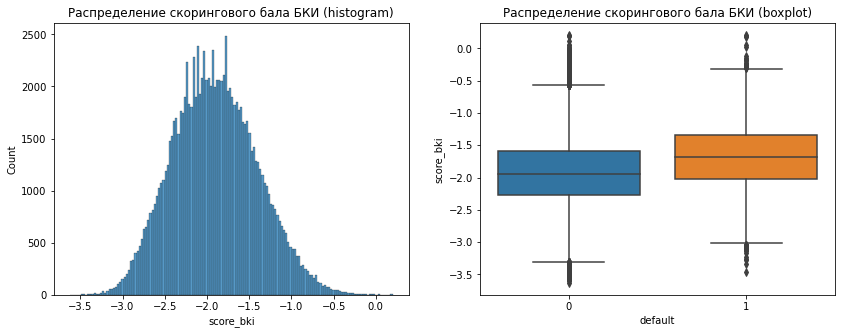

In [34]:
number_graph(df, df['score_bki'], 'Распределение скорингового бала БКИ')

По гистограмме можно заключить, что рапределение признака досточно близко к нормальному. На boxplot'е можно увидеть выбросы, достаточно плотно собранные у границ графиков. Медианное значение для дефолтных значений оценки БКИ, оказалось больше, чем у не дефолтных заемщиков. Нам не известна методика оценки скорингового балла БКИ, но следует обратить внимание на отрицательные значения данного признака.

Как указывалось ранее, в данном параметре есть выборосы. Произведем их оценку.

In [35]:
outs, min_out, max_out = outliers(df['score_bki'])
print_outliers(df, outs)

Выбросы: 518 (0.47%)


Доля выбросов незначительна. Можно избавимся от них методом удаления строк датасета с выбросами.

In [36]:
mask1 = df['score_bki'] > min_out
mask2 = df['score_bki'] < max_out
df = df[mask1 & mask2]

Рассматриваемый признак является числовым. Добавим его к другим числовым признакам в соответствующий список.

In [37]:
num_cols.append('score_bki')

***Выводы.***
1. Распределение признака *score_bki* близко к нормальному.
2. Признак *score_bki* - числовой.

***2.2.11. Признак bki_request_cnt - количество запросов в БКИ***

По структуре данных признак числовой, имеющий несколько десятков возможных значений. Посмотрим их поближе.

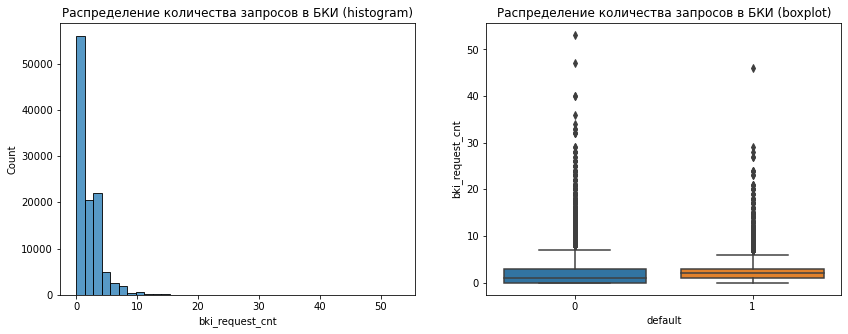

In [38]:
number_graph(df, df['bki_request_cnt'], 'Распределение количества запросов в БКИ')

По первому графику видно, что распределение похоже на экспоненциальное. Во второму - видно множественные выбросы за границами усов boxplot'а. Оценим количество и долю выбросов.

In [39]:
outs, min_out, max_out = outliers(df['bki_request_cnt'])
print_outliers(df, outs)

Выбросы: 2569 (2.34%)


Доля выбросов достаточно большая. Пробуем прологарифмировать значения признака.

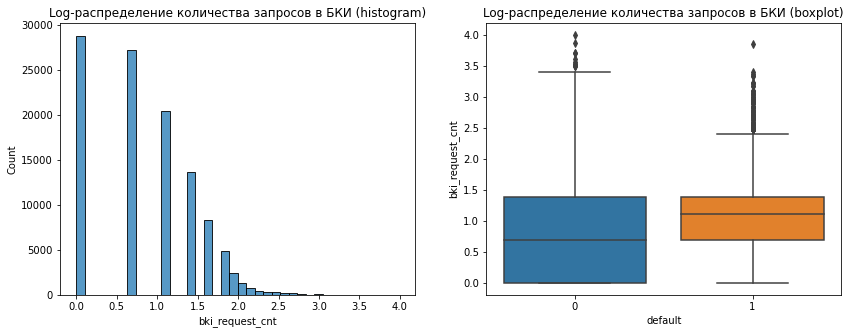

In [40]:
number_graph(df, np.log(df['bki_request_cnt']+1), 'Log-распределение количества запросов в БКИ')

Визуально результат лучше. Распределение признака стало ближе к нормальному. Выбросов стало меньше. Проанализируем их.

In [41]:
outs, min_out, max_out = outliers(np.log(df['bki_request_cnt']+1))
print_outliers(df, outs)

Выбросы: 12 (0.01%)


Полученное значение выбросов после логарифмирования признака, позволяет "улчшить" признак для обучения модли скоринга. Поэтому производим оговоренное ранее реобразование признака в датасете и удаляем оставщиеся выбросы.

In [42]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt']+1)
mask1 = df['bki_request_cnt'] > min_out
mask2 = df['bki_request_cnt'] < max_out
df = df[mask1 & mask2]

Отнесем расматриваемый признак к числовым и зафиксируем это в списке таких признаков.

In [43]:
num_cols.append('bki_request_cnt')

***Выводы.***
1. Признак *bki_request_cnt* - числовой.
2. Произведена подготовка признака *bki_request_cnt* для использования при обучении модели скоринга.

***2.2.12. Признак region_rating - рейтинг региона***

Числовое значение признака и 7 его уникалных значений позволяют предположить, что данный признак будет категориальным. Рассмотрим его более подробно.

50    40806
60    23900
40    17876
80    17061
70     9232
30      433
20      310
Name: region_rating, dtype: int64


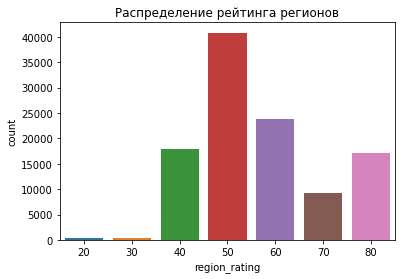

In [44]:
print(df['region_rating'].value_counts())
sns.countplot(data=df, x=df['region_rating']).set(title='Распределение рейтинга регионов');

Видно, что в данном признаке содержится рейтинги в диапазоне от 20 до 80. Наличие фиксированного количества значений признака позволяет определить его как категориальный. Занесем его в список категориальных признаков для дальнейшей обработки.

In [45]:
cat_cols.append('region_rating')

***Вывод.*** Признак *region_rating* является категориальным. 

***2.2.13. Признаки home_address и work_address - категоризаторы домашнего и рабочего адреса***

Уже в самом описании признаков заявлены их категориальная природа. Убелимся в этом рассмотрев их более предметно.

2    59266
1    48491
3     1861
Name: home_address, dtype: int64


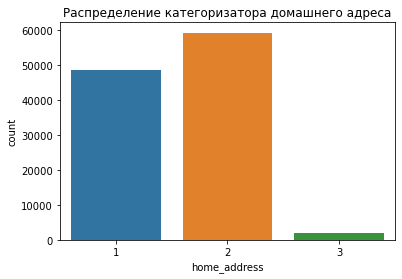

In [46]:
print(df['home_address'].value_counts())
sns.countplot(data=df, x=df['home_address']).set(title='Распределение категоризатора домашнего адреса');

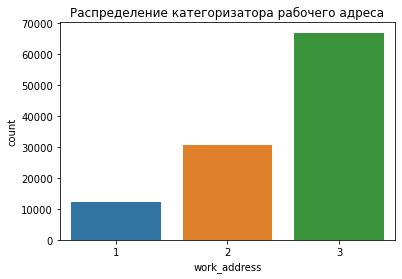

In [47]:
df['work_address'].value_counts()
sns.countplot(data=df, x=df['work_address']).set(title='Распределение категоризатора рабочего адреса');

По заданию не определено значения кодов категоризатоа. Но если исходить из названия признаков, то можно предположить следующие значения:

1. Частный домовладение или пригород.
2. Квартира или черта города.
3. Промышеленная зона или деловой квартал.

Занесем данные признаки в список категориальных переменных.

In [48]:
cat_cols.append('home_address')
cat_cols.append('work_address')

***Выводы.***
1. Признак *home_address* является категориальным.
2. Признак *work_ address* является категориальным.

***2.2.14. Признак income - доход заемщика***

В структуре данных рассматриваемый признак заявлен как числовой. Имеет достаточно большое количество уникальных значений. Посмотрим распределение данного параметра графически, а так же сразу же оценим выбросы.

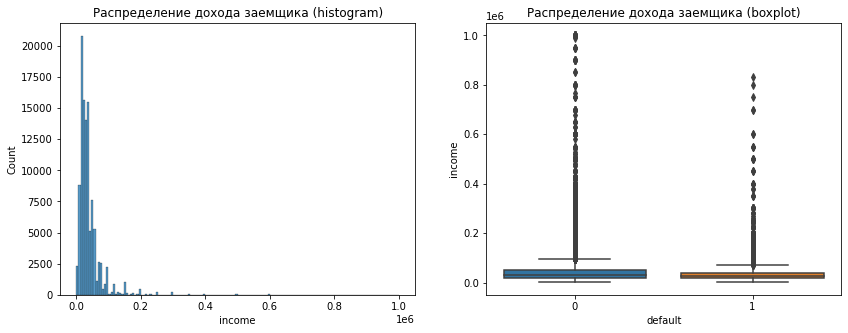

Выбросы: 6939 (6.33%)


In [49]:
number_graph(df, df['income'], 'Распределение дохода заемщика')
print_outliers(df, outliers(df['income'])[0])

Распределение по гистограмме не ясно, но имеет достаточно длинный "хвост" справа. В boxplot'ах прослеживается большое количество выбросов. Это подтверждается и расчетом доли выбросов. Попробуем пролагарифмировать значения признака и снова постоить распределения.

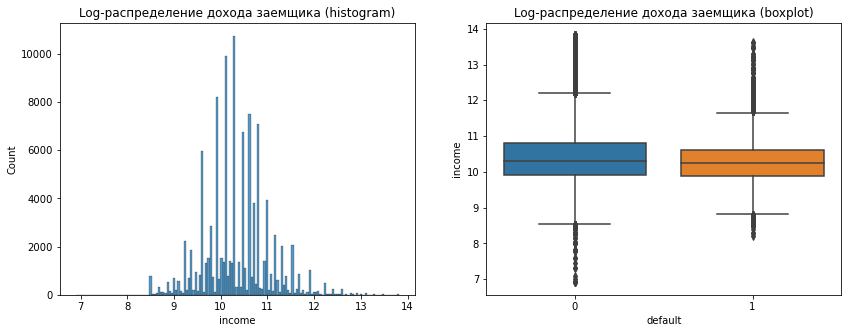

Выбросы: 2585 (2.36%)


In [50]:
number_graph(df, np.log(df['income']), 'Log-распределение дохода заемщика')
print_outliers(df, outliers(np.log(df['income']+1))[0])

Видно, что распределение стало похоже на нормальное. Количество выбросов сократились почти в 3 раза. С учетом значимости признака дохода заемшщика для модели скоринга, мы не будем удалять оставшиеся выбросы. Применим логарифмирование к признаку в датасете и занесем данный признак в спиок числовых. 

In [51]:
df['income'] = np.log(df['income']+1)
num_cols.append('income')

***Выводы.***
1. Признак *income* - числовой.
2. Произведена подготовка признака *income* для обучения создаваемой модели.

***2.2.15. Признак sna - связь заемщика с клиентами банка***

По структуре данных данный признак целочисленный числовой и имеет 4 уникальных значения. Все это определяет его как категориальный. Расмотрим этот признак более детально.

1    70358
4    17394
2    15750
3     6116
Name: sna, dtype: int64


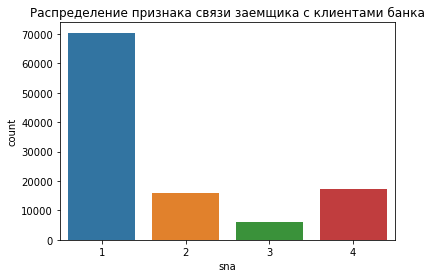

In [52]:
print(df['sna'].value_counts())
sns.countplot(data=df, x=df['sna']).set(title='Распределение признака связи заемщика с клиентами банка');

Из гистограммы вмдны 4 явно выраженные группы, т.е. у нас имееися категориальный тип признака. Занесем данный признак в список категориальных признаков.

In [53]:
cat_cols.append('sna')

***Вывод.*** Признак *sna* является категориальным.

***2.2.16. first_time - давность наличия информации о заемщике***

Данный признак имеет четыре уникальных значения. Возможно - это категории. Проверим это утверждение.

3    46374
4    27890
1    18201
2    17153
Name: first_time, dtype: int64


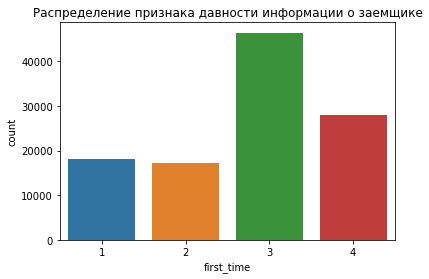

In [54]:
print(df['first_time'].value_counts())
sns.countplot(data=df, x=df['first_time']).set(title='Распределение признака давности информации о заемщике');

Видно четыре возможных значения, в диапазоне от 1 до 4. Это 4 явных категории. Отнесем данный тип к категориальным и зафиксируем его в соответствующем списке.

In [55]:
cat_cols.append('first_time')

***Вывод.*** Признак *first_time* является категориальным.

***2.2.17. Признак foreign_passport - наличие загранпаспорта***

Два уникальных значения данного признака предполагает бинарность данного признака. Посмотрим графически его распределение.

N    93291
Y    16327
Name: foreign_passport, dtype: int64


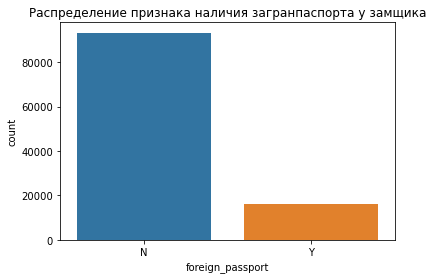

In [56]:
print(df['foreign_passport'].value_counts())
sns.countplot(data=df, x=df['foreign_passport']).set(title='Распределение признака наличия загранпаспорта у замщика');

Использование обозначения Y/N подтверждает, что признак бинарный. Так же можно отметить, что заемщиков имеющих загранпаспорт в несколько раз меньше, чем без загранпаспорта. Добавим данный признак в список бинарных признаков для дальнейшей обработки.

In [57]:
bin_cols.append('foreign_passport')

***Выводы.***
1. В выборке данных преобладают заемщики не имеющие загранпаспорта.
2. Признак *foreign_passport* - бинарный.

***2.2.18. Признак *sample* - флаг указания оучающей/тестовой выборки***

Служебный признак, который мы ввели при объединении обучающего и тестового датасета. Предназначен для возможности последующего разделения выборок после предобработки данных. В обучении модели данный признак использоваться не будет.

***Вывод.*** Признак *sample* не будет использоваться при обучении модели.

***2.2.18. Признак default - флаг дефолта по кредиту***

Данный признак - это целевой признак, который должен стать результатом работы созданной нами модели. Т.к. его значение для тестовой части выборки не определениы, то рассмотрим его распределение только на обучающей выборке.

0    64427
1     9372
Name: default, dtype: int64


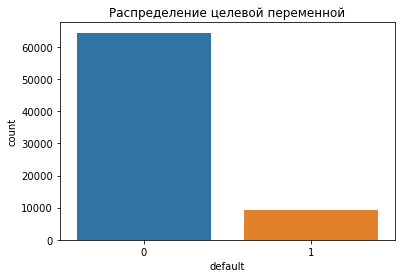

In [58]:
# Смотрим на df_train, где есть значения целевого признака
print(df_train['default'].value_counts())
sns.countplot(data=df_train, x=df_train['default']).set(title='Распределение целевой переменной');

Наличие дефолтных заемщиков в 7 раз меньших чем не дефолтных - это хорошо для банка. Но не хорошо для обучения модели, т.к. данные являются разбалансированными. Необходимо учитывать данное обстоятельство при построении модели и ее оптимизации.

***Вывод.*** Данных целевого признака *default* достаточно для обучения модели, но их разбалансировка может привести к понижению точности ее работы.

***2.3. Анализ числовых признаков***

Рассмотрим полученные признаки, которые были отнесены к числовым.

In [59]:
num_cols

['app_month', 'app_day', 'age', 'score_bki', 'bki_request_cnt', 'income']

Добавим к этому списку целевой признак и построим матрицу корреляции числовых признаков.

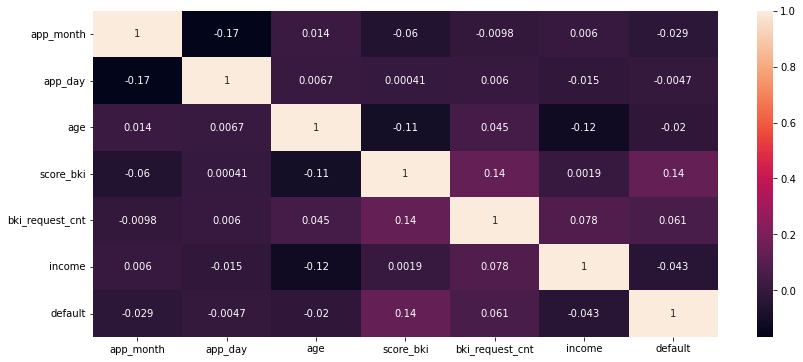

In [60]:
plt.figure(figsize=(14,6))
sns.heatmap(df[num_cols+['default']].corr(), annot=True);

Анализируя матрицу корреляции можно отметить, что в целом числовые признаки связаны между собой слабой корреляционной связью, что подходит нам для обучения модели. Отдельно выделим связи с наибольшими по модулю значениями.
- *app_day* и *app_month* - закономерно, т.к. это составные части одной даты и входят в ограниченный сисок дат в году;
- *score_bki* и *bki_request_cnt* - можно сделать вывод, что оценка БКИ явно связана с количеством обращений в БКИ по заемщику;
- *score_bki* и *default* - скоринговые баллы БКИ оказывают наибольшее влияние на целевой признак, по сравнению с другими числовыми признаками;
- *age* и *income* - существование связи между этими параметрами реально существует, но не очень понятно только появление обратной связи, возможно это особенность данной выборки;
- *age* и *score_bki* - оценка БКИ явно учитывает возраст заемщика, но как упониналось ранее, для более детального понимания взаимосвязи со скоринговыми балами БКИ необходимо знать методику их расчетов.

Рассмотрим значимость непрерывных признаков.

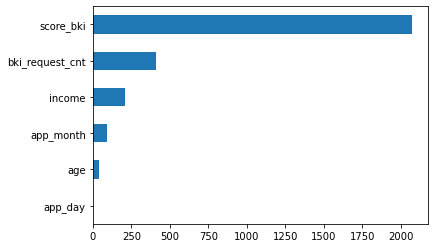

In [61]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Как и указывалось выше, наибольшее влияние на целевой признак оказывает *score_bki*, значительно превышая остальные признаки.

***Выводы.***
1. Все выбранные числовые признаки можно использовать при обучении модели.
2. Наибольшее влияние из числовых признаков на целевой признак оказывает *score_bki*.

***2.4. Обработка и анализ бинарных признаков***

Обратимся к списку бинарных признаков датасета. Все признаки кроме *good_work* требуют преобразования к числам. Проведем это преобразование.

In [62]:
print(bin_cols)
label_encoder = LabelEncoder()
for column in bin_cols:
    if column != 'good_work':
        df[column] = label_encoder.fit_transform(df[column])
df.head(3) # Проверим результат

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,app_month,app_day
0,25905,SCH,1,62,1,1,0,0,-2.008753,0.693147,...,1,2,9.798183,4,1,0,0,1,2,1
1,63161,SCH,0,59,0,0,0,0,-1.532276,1.386294,...,2,3,9.852247,4,1,0,0,1,3,12
2,25887,SCH,1,25,1,0,2,0,-1.408142,0.693147,...,1,2,10.308986,1,4,1,0,1,2,1


Посмотрим значимость бинарных признаков по отношению к целевому признаку.

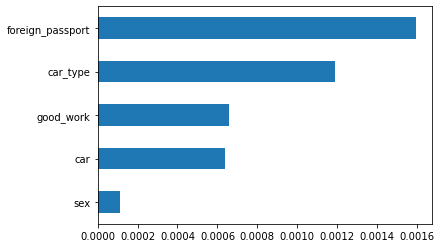

In [63]:
imp_bin = pd.Series(mutual_info_classif(df[bin_cols], df['default'], discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh');

Из графика видно, что наиболее значимым оказался признак *foreign_passport*. Чуть менее значимым - *car_type*. Признаки *good_work* и *car* оказывают примерно одинаковое воздействие на целевой признак, но примерно в 2 с лишним раза меньшее чем *foreign_passport*.

***Выводы.***
1. Все бинарные признаки приготовлены к обучению модели.
2. Наиболее значимым бинарным признаком является *foreign_passport*.

***2.5. Обработка и анализ категориальных признаков***

Рассмотрим полученный список категориальных переменных.

In [64]:
cat_cols

['education',
 'decline_app_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

Значения признаков *education* и *region_rating* требуют дополнительной обработки. Преобразуем их значения в числа.

In [65]:
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df['region_rating'] = label_encoder.fit_transform(df['region_rating'])

Оценим значимость категориальных признаков.

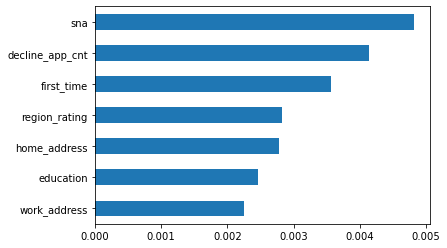

In [66]:
imp_cat = pd.Series(mutual_info_classif(df[cat_cols], df['default'], discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Все категориальные признаки оказывают значимое влияние на целевую переменную. Все будут использоваться при обучении модели. Произведем преобразование этих признаков в индикаторные значения.

In [67]:
df = pd.get_dummies(df, columns=cat_cols)
df.info() # Проверка результата

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109618 entries, 0 to 110147
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          109618 non-null  int64  
 1   sex                109618 non-null  int32  
 2   age                109618 non-null  int64  
 3   car                109618 non-null  int32  
 4   car_type           109618 non-null  int32  
 5   good_work          109618 non-null  int64  
 6   score_bki          109618 non-null  float64
 7   bki_request_cnt    109618 non-null  float64
 8   income             109618 non-null  float64
 9   foreign_passport   109618 non-null  int32  
 10  default            109618 non-null  int64  
 11  sample             109618 non-null  int64  
 12  app_month          109618 non-null  int64  
 13  app_day            109618 non-null  int64  
 14  education_0        109618 non-null  uint8  
 15  education_1        109618 non-null  uint8  
 16  ed

***Выводы.***
1. Подготовили категориальные данные для обучения модели.
2. Все категориальные признаки оказывают значимое влияние на целевую переменную.

**3. Обучение модели**

***3.1. Разбиение данных на части***

Выделим из общего датасета тестовую часть, которая ранее была помечена через признак *sample*=0. Также уберем служебные признаки, котрые мы добавляли при объединении изначальных выборок.

In [68]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'default'], axis=1)

Проведем нормализацию значений числовых признаков.

In [69]:
for col in num_cols:
    train_data[col] = StandardScaler().fit_transform(train_data[[col]].values)

Подготовим датафрейм train_data для использования при обучении модели.

In [70]:
X = train_data.drop(['client_id', 'default'], axis=1).values
y = train_data['default'].values # целевой признак

Для проверки модели до отправки submission на kaggle, разобъем полученные данные на тренировочные и валидационные части в пропорции 4:1.

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((58762, 42), (14691, 42), (58762,), (14691,))

***3.2. Обучение и оценка базовой модели***

Проведем обучение с рекомендованными по baseline параметрами.

In [72]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
y_prob = logreg.predict_proba(X_valid)[:,1]

Сформируем графические и табличные оценочные результаты полученной модели.

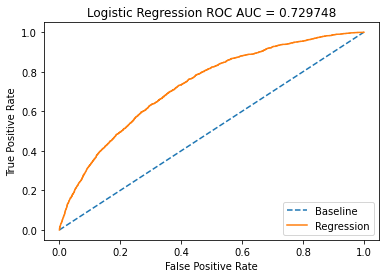

,base
accuracy,0.873868
f1,0.048279
roc_auc,0.729748
confusion,"[[12791, 47], [1806, 47]]"


In [73]:
results = pd.DataFrame.from_dict(get_metrics(y_valid, y_pred, y_prob), orient='index', columns=['base'])
roc_auc_graph(y_valid, y_prob)
results

Полученные значения метрик будем использовать как базовые для сравнения с другими вариантами моделей. Следует обратить внимание на значения матрицы ошибок, которые говорят о недостаточно "хорошем" определении дефолтов заемщиков. Присутствует достаточно большое количество ложноотрицательных заключений. Это ошибка второго рода. Это может быть связано с несбалансированностью целевой переменной. Об этом уже упоминалось в п.2.2.18.

***Выводы.***
1. Необходимо попытаться улучшить качество модели, по сравнению с метриками базовой модели.
2. Ошибка второго рода в предсказании также указаывает на необходимость поиска более точной модели.

***3.3. Обучение и оценка сбалансированной модели***

Попробуем произвести балансировку обучающей выборки с помощью метода *undersampling*. Выраниваем по целевому признаку *default*.

In [74]:
val = train_data['default'].value_counts(ascending=True)
n = val.iloc[0]
minor = train_data[train_data['default'] == val.index[0]]
add = train_data[train_data['default'] == val.index[1]][:n]
train_balanced = pd.concat([add, minor])

Проведем подготовку и разделение полученного датафрейма *train_balanced* для последующего обучения модели с теми же прараметрами, что и раньше.

In [75]:
X = train_balanced.drop(['client_id', 'default'], axis=1).values
y = train_balanced['default'].values # целевой признак
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((14820, 42), (3706, 42), (14820,), (3706,))

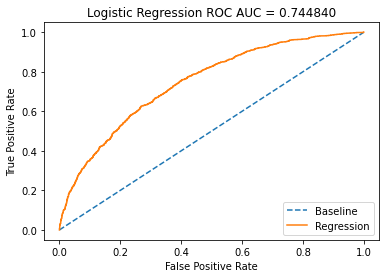

,base,balanced
accuracy,0.873868,0.674582
f1,0.048279,0.672104
roc_auc,0.729748,0.74484
confusion,"[[12791, 47], [1806, 47]]","[[1264, 612], [594, 1236]]"


In [76]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
y_prob = logreg.predict_proba(X_valid)[:,1]

results['balanced'] = pd.Series(get_metrics(y_valid, y_pred, y_prob))
roc_auc_graph(y_valid, y_prob)
results

Величина метрики f1 значительно выросла, что говорит что модель более успешно справилась с задачей дисбаланса двоичной классификации. Незначительно, но увеличилась метрика roc_auc. Это тоже говорит об улучшении модели. Также можно отметить изменнеие в матрице ошибок. Теперь значения на главной ее диагонали почти выровнялись, что означает улучшение предсказаний дефлотов.

***Выводы.***
1. Используя метод *undersampling* удалось сбалансировать исходные данные так, что теперь модель дает более равномерные предсказания дефолтных и недефолтных заемщиков.
2. Метрика *f1* значительно возросла, по сравнению с базовой моделью.
3. Упала метрика *accuracy* и стало больше ложных предсказаний, но для улучшения этих параметров нужна большая выборка данных.
4. Попытаемся улушить эту модель с помощью подбора гиперпараметров.

***3.4. Подбор гиперпараметров для улучшения модели***

Попробуем найти опимальные парамеры для регуляризации логической регрессии с помощью поиска гиперпараметров *GridSearchCV* при помощи перебора парметров по сетке *param_grid*.

In [77]:
logreg = LogisticRegression()

iter_ = 1000
epsilon_stop = 1e-5

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'newton-cg'
	tol: 1e-05
	verbose: 0
	warm_start: False


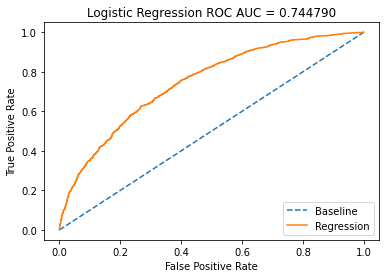

,base,balanced,hyperparam
accuracy,0.873868,0.674582,0.674042
f1,0.048279,0.672104,0.671382
roc_auc,0.729748,0.74484,0.74479
confusion,"[[12791, 47], [1806, 47]]","[[1264, 612], [594, 1236]]","[[1264, 612], [596, 1234]]"


In [78]:
logreg = LogisticRegression(class_weight=None, max_iter=1000, penalty='none', 
                           solver='newton-cg', tol=1e-5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
y_prob = logreg.predict_proba(X_valid)[:,1]

results['hyperparam'] = pd.Series(get_metrics(y_valid, y_pred, y_prob))
roc_auc_graph(y_valid, y_prob)
results

***Вывод.*** Из результирующей таблицы видно, что подбор гиперпараметров не привел к принципиальному измененнию контрольных метрик. Они даже немного ухудшились. Исходя из этого выбираем сбалансированную модель как наилучшую.

**4. Формирование файла Submission**

Для отправки результатов работы созданной модели на *kaggle* необходимо сформировать файл *submission.csv*, который содержит датафрейм с признаками *client_id* - идентификатор клиента и *default* - флаг дефолта по клиенту, предсказанный по результатам работы нашей модели.

Обучаем нашу лучшую модель на полных обучающих данных и формируем датафрейм для отправки.

In [79]:
logreg_final = LogisticRegression(solver='liblinear', max_iter=1000)
logreg_final.fit(X, y)

predict_submission = logreg_final.predict(test_data.drop(['client_id'], axis=1))
submission = pd.DataFrame(test_data['client_id'])
submission['default'] = predict_submission
submission.to_csv('submission.csv', index=False)
submission.describe()

,client_id,default
count,36165.000000,36165.000000
mean,54968.458814,0.000249
std,31703.891817,0.015774
min,4.000000,0.000000
25%,27777.000000,0.000000
50%,54696.000000,0.000000
75%,82341.000000,0.000000
max,110148.000000,1.000000


In [80]:
submission['default'].value_counts()

0    36156
1        9
Name: default, dtype: int64

***Выводы.***
1. Произвели предсказание по выбранной модели для тестовых данных, заданных изначально.
2. Подготовили и отправили в *kaggle* файл *submission.csv* с итогами предсказания дефолтов заемщиков на основании тестовых данных.
3. По результатам работы выбранной модели предсказано 9 дефолтов заемщиков.

**5. Общие выводы по проекту**

В ходе выполнения проекта были произведены выполнены следующие действия:

1. Произведена загрузка и первичное знакомство с предложенными для обработки данными.
2. Произведена предобработка данных с детальным анализом всех признаков выборки.
3. Произведено разделение признаков на группы по типам предобработки. Над группами признаков выполнены требуемые преобразования.
4. Произведено создание нескольких вариантов моделей банковского скоринга используя логическую регрессию.
5. На основе контрольных метрик, произведены оценки полученных моделей и выбрана наилучшая.
6. Используя выбранную модель, произведено предсказание дефолтов заемщиков на основе предложенных тестовых данных.
7. Итоги предсказанных значений дефолтов отправлены в *kaggi*.

В результате работы над проектом получен опыт по настройке и анализу модели логиеской регрессии, изучено влияние данных на ее качество, а так же произведено применение созданной модели для расчета практических результатов.